<div align='left'><font size="6" color="#FFA500">Principal Component Analysis (PCA) in Python</font></div>

<hr>

PCA có nghĩa là phân tích thành phần chính, đây là kỹ thuật phổ biến được dùng để giảm chiều của dữ liệu
mà vẫn dữ lại được những đặc trưng quan trọng. 

Ý tưởng của nó là:
* Xác định siêu phẳng nằm gần với dữ liệu nhất
* Chiếu dữ liệu lên siêu phẳng đó

![](https://i.stack.imgur.com/Q7HIP.gif)

[Projecting 2D-data to a line (PCA)](https://i.stack.imgur.com/Q7HIP.gif)

Tuy nhiên, việc lựa chọn siêu phẳng phù hợp là rất quan trọng để khi dữ liệu được chiếu lên đó nó giữ lại phương sai lớn nhất.

Nói cách khác, khoảng cách trung bình bình phương giữa các điểm dữ liệu gốc và hình chiếu của chúng là nhỏ nhất

Chọn phương sai lớn nhất vì phương sai phản ánh mức độ phân tán hay thông tin về cách phân bố của dữ liệu gốc, bằng cách này khi PCA giảm thiểu sự thất thoát dữ liệu gốc


![](https://i.stack.imgur.com/lNHqt.gif)

## Principal Components

Trục mà có phương sai lớn nhất trong bộ dữ liệu được gọi là các thành phần chính thứ nhất (principal components). 

Trục vuông góc với trục này được gọi là thành phần chính thứ hai (second principal components). 

Tuỳ thuộc vào có bao nhiêu chiều không gian, sẽ có bấy nhiêu trục vuông góc với nhau ứng các các thành phần chính.

Ở không gian 2 chiều, có 2 thành phần chính.

![](https://hackernoon.com/hn-images/1*WRKdN-NYF0mMumhfOXVa2Q.png)

Source : [A Layman’s Introduction to Principal Components](https://hackernoon.com/a-laymans-introduction-to-principal-components-2fca55c19fa0)

# Load dataset

In [2]:
# Read data
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)

In [3]:
# Read data description: https://archive.ics.uci.edu/ml/datasets/wine
# Columns names (1 - 13): Alcohol, Malic acid, Ash, Alcalinity of ash, Magnesium, Total phenols, Flavanoids
# Nonflavanoid phenols, Proanthocyanins, Color intensity, Hue, OD280/OD315 of diluted wines, Proline
# Label column (column 0): Wine quality
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [4]:
X, y = data.iloc[:, 1:].values, data.iloc[:, 0].values

In [5]:
N, d = X.shape

print("Num. samples: ", N)
print("Num. features/variables: ", d)

Num. samples:  178
Num. features/variables:  13


## Nhắc lại các bước của thuật toán PCA
1. Chuẩn hóa dữ liệu
2. Xây dựng ma trận hiệp phương sai từ dữ liệu đã được chuẩn hoá
3. Tìm các vector riêng, trị riêng của ma trận hiệp phương sai (bằng eigen-decomposition hay SVD)
4. Xây dựng tập trực chuẩn từ tập hợp các vector trên
5. Sắp xếp các trị riêng theo chiều giảm dần
6. Chọn $k$ vector riêng đầu tiên ứng với $k$ trị riêng đầu tiên trong bộ trị riêng có thứ tự ở bước trên $(k << d)$
7. Xây dựng ma trận chiếu $W$ từ các vector riêng trên
8. Tìm hình chiếu $Y$ của ma trận dữ liệu $X$ trong không gian mới sinh bởi ma trận $W$, khi đó $Y$ = $WX$

## PCA với Eigen-decomposition


### Chuẩn hoá dữ liệu 

In [6]:
from sklearn.preprocessing import StandardScaler

# Chuẩn hóa dữ liệu bằng thư viện 
sc = StandardScaler()
X_std = sc.fit_transform(X)

In [7]:
# sklearn dùng phương sai không hiệu chỉnh!
(X_std == (X - X.mean(axis = 0))/X.std(axis = 0, ddof = 0)).all()

True

Công thức chuẩn hoá  
$$X_{std} = \frac{X - \bar{X}}{S}$$
Với S là độ lệch chuẩn có công thức
$$S^2 = \frac{\sum_{i=1}^{n} (X - \bar{X})^2}{N-1}$$

Thư viện sklearn sử dụng phương sai không hiệu chỉnh nên để tính toán phương sai chính xác hơn chúng ta sử dụng phương sai hiệu chỉnh (chia N-1 thay vì N)

In [8]:
# Xem thêm: https://numpy.org/doc/stable/reference/generated/numpy.std.html

X_std = (X - X.mean(axis = 0))/X.std(axis = 0, ddof = 1)

# Hay

S = sum((X - X.mean(axis=0))**2)/(N-1)
X_std_2 = (X - X.mean(axis = 0))/np.sqrt(S)

In [9]:
# Tính tay và dùng thư viện cho ra một kết quả
np.allclose(X_std,X_std_2)

True

### Tính ma trận hiệp phương sai

In [10]:
# Sử dụng thư viện
cov_mat_np = np.cov(X_std.T)

Công thức tính ma trận hiệp phương sai cho dữ liệu đã chuẩn hoá
$$Cov =  \frac{X_{std}^TX_{std}}{N-1}$$

In [11]:
# Không sử dụng thư viện
N = X.shape[0]
cov_mat =(X_std.T @ X_std) / (N - 1)


In [12]:
# So sánh với hàm thư viện
cov_mat_np = np.cov(X_std.T)
np.allclose(cov_mat,cov_mat_np)

True

### Tìm vector riêng, trị riêng của ma trận hiệp phương sai (bằng eigen_decomposition)

In [13]:
# Sử dụng np.linalg.eigh
eigenvals, eigenvecs = np.linalg.eigh(cov_mat)

Tổng hợp hàm

In [14]:
def find_eigen(X):
    '''
    Trả về trị riêng và vector riêng đã sắp xếp giảm dần theo trị riêng
    '''
    # Chuẩn hóa dữ liệu với phương sai hiệu chỉnh
    N = X.shape[0]
    S = sum((X - X.mean(axis=0))**2)/(N-1)
    X_std = (X - X.mean(axis = 0))/np.sqrt(S)

    # Tính ma trận hiệp phương sai
    cov_mat =(X_std.T @ X_std) / (N - 1)

    # Tìm trị riêng, vector riêng của ma trận hiệp phương sai mẫu
    eigenvals, eigenvecs = np.linalg.eigh(cov_mat)

    # Sắp xếp cặp (trị riêng, vector riêng) với trị riêng theo chiều giảm dần
    eigenpairs = [(abs(eigenval), eigenvec) for (eigenval, eigenvec) in zip(eigenvals, eigenvecs.T)]
    eigenpairs = sorted(eigenpairs, key = lambda pair: pair[0], reverse = True)

    return eigenpairs


In [15]:
eigenpairs = find_eigen(X_std)
# 1) Lấy ra các trị riêng
eigenvals = [eigenval for (eigenval, _) in eigenpairs]
eigenvals = np.array(eigenvals) 
# sum(eigenvals) ~= d vì khi đó ta lấy tất cả trị riêng, tức không có giảm chiều dữ liệu nên tổng tích bằng d (số feature)

# 2) Tính tổng tích lũy các trị riêng
cumsum = np.cumsum(eigenvals)

# 3) Tính phần trăm phương sai giải thích (explained variance) bởi từng PC
cumsum /= cumsum[-1]

### Xây dựng tập trực chuẩn

Việc dùng `np.linalg.eigh` đảm bảo cho họ của các vector riêng trực chuẩn

Khi nói các vector riêng trực chuẩn:

- Tức là các vector riêng phải độc lập tuyến tính 

- Các vector riêng phải vuông góc với nhau (tích vô hướng bằng 0)

- Thể hiện qua biểu đồ heatmap của các tích các vector riêng


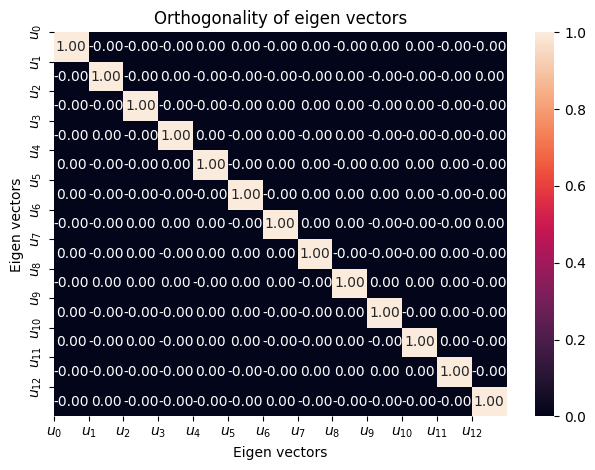

In [16]:
import seaborn as sns

# chọn các vector riêng từ danh sách các cặp trị riêng-vector riêng
eigenvecs = np.array([eigenvec for (_, eigenvec) in eigenpairs]) 

# Ma trận chứa các giá trị tích vô hướng của từng cặp vector riêng.
# eg: table[i,j] = u_i.T @ u_j
table = np.zeros((len(eigenvecs), len(eigenvecs)))

# labels
labels = [f'$u_{{{i}}}$' for i in range(len(eigenvecs))]

fig, ax = plt.subplots()

# Tính dot-product của từng cặp vector riêng `u_i.T @ u_j`
for i, vec_x in enumerate(eigenvecs):
    for j, vec_y in enumerate(eigenvecs):
        table[i, j] = vec_x.T.dot(vec_y)

sns.heatmap(table, annot=True, fmt='.2f', ax=ax)

ax.set(xlabel='Eigen vectors', 
       ylabel='Eigen vectors', 
       title='Orthogonality of eigen vectors', 
       xticks=np.arange(len(eigenvecs)),
       yticks=np.arange(len(eigenvecs)),
       xticklabels=labels,
       yticklabels=labels)

plt.tight_layout()
plt.show()

Có thể thấy các tích đều bằng 0 chứng tỏ tính trực chuẩn của nó

### Chọn $k$ vector riêng đầu tiên ứng với $k$ trị riêng đầu tiên trong bộ trị riêng có thứ tự $(k << d)$


Số vector riêng được chọn tương tương đương với số thành phần chính quyết định giữ lại

Trước khi đi vào thuật toán xác định số thành phần chính trong PCA, chúng ta điểm qua 1 vài tiêu chí có sẵn để quyết định số thành phần chính cần giữ lại:

- Xác định số lượng PC qua kinh nghiệm và lý thuyết.

- Lựa chọn số lượng PC dựa vào khả năng giải thích cho toàn bộ các biến ban đầu `(explain variances)`.

- Lựa chọn số lượng PC bằng cách kiểm tra các giá trị riêng theo nguyên tắc khuỷu tay `(elbow method)`.

Vẽ đồ thị Scree để trực quan 

In [17]:

def screeplot(eigenpairs):
    '''
    Vẽ đồ thị scree
    -----------------------
    Tham số:
        eigenpairs: list-like
            Cặp (trị riêng, vector riêng) có từ thuật toán PCA
    -----------------------
    Trả về: None
        Vễ đồ thị scree biểu diễn lượng thông tin có được ứng với mỗi vector riêng
    '''
    fig, axes = plt.subplots(nrows = 2, ncols = 1, sharex = True)
    eigenvals = [eigenval for (eigenval, _) in eigenpairs]
    eigenvals = np.array(eigenvals)
    cumsum = np.cumsum(eigenvals)
    cumsum /= cumsum[-1]

    # vẽ đồ thị line-plot
    axes[0].plot(range(len(eigenvals)), eigenvals, marker = '.', color = 'b', label = 'Eigenvalue')
    axes[1].plot(range(len(cumsum)), cumsum, marker = '.', color = 'r', label = 'Cumulative propotion')
    
    # hiển thị nhãn cho trục tung
    axes[0].set_ylabel('Eigen values')
    axes[1].set_ylabel('Cumulative explained variance')

    # hiển thị mô tả của đồ thị
    axes[0].legend()
    axes[1].legend()

    # tạo lưới
    axes[0].grid()
    axes[1].grid()

    # tạo tiêu đề chung cho figure
    fig.supxlabel('Number of components')
    plt.tight_layout()
    plt.show()

> NOTE: Tiêu chí chọn số PC

- Dựa vào trị riêng: chọn điểm mà biểu đồ trị riêng giảm đột ngột trở nên phẳng hoặc giảm chậm `(elbow point)`

- Theo tổng tích lũy phương sai giải thích thì chọn ứng với tỷ lệ dữ liệu muốn dữ lại

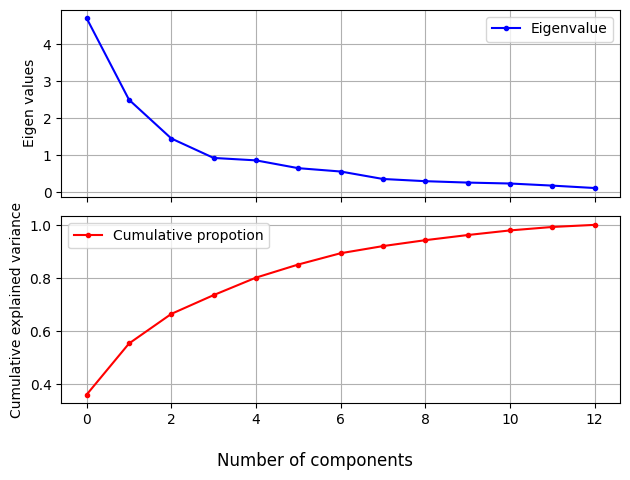

In [18]:
screeplot(eigenpairs)

**Nhận xét**: Đồ thị scree khá thoải

- Có nghĩa là đồ thị giảm dần một cách tuyến tính hoặc giảm chậm qua các thành phần chính. 

- Khi đồ thị scree của trị riêng không có điểm "khuỷu tay" (elbow point) rõ rệt, điều này thường chỉ ra rằng mỗi thành phần chính vẫn giữ lại một lượng thông tin quan trọng từ dữ liệu.

- Dẫn đến việc ta cần nhiều Principal Components để giữ nhiều thông tin của dữ liệu

Hàm tìm số PC ứng với số dữ liệu muốn dữ lại

In [19]:
# utils
def find_num_pc(eigenpairs, thres = 0.95):
    '''
    Tìm số lượng vector thành phần chính
    -----------------------
    Các tham số:
        eigenpairs: list-like
            Cặp (trị riêng, vector riêng) có từ thuật toán PCA
        thres: float, default = 0.95
            Ngưỡng thông tin ta muốn giữ lại từ dữ liệu (mặc định ta giữ lại 95% dữ liệu ban đầu)
    -----------------------
    Trả về:
        Số lượng vector thành phần chính
    '''
    # 1) Lấy ra các trị riêng
    eigenvals = [eigenval for (eigenval, _) in eigenpairs]
    eigenvals = np.array(eigenvals)
    
    # 2) Tính tổng dồn các trị riêng
    cumsum = np.cumsum(eigenvals)
    
    # 3) Tính phần trăm
    cumsum /= cumsum[-1]

    # 4) Lặp từng phần tử trong cumsum, khi nào phần trăm cộng dồn vừa đến ngưỡng thì ta dừng
    for i, val in enumerate(cumsum):
        if val >= thres:
            return i + 1


In [20]:
# Cần 10 vector thành phần chính ta mới có thể giữ lại 95% thông tin của dữ liệu
find_num_pc(eigenpairs, thres = 0.95)

10

### Xây dựng ma trận chiếu w và tìm hình chiếu

In [21]:

def construct_W(eigenpairs):
    '''
    Xây dựng ma trận chiếu W từ cặp (trị riêng, vector riêng) có được từ thuật toán PCA
    -----------------------
    Các tham số:
        eigenpairs: list-like
            Danh sách các cặp (trị riêng, vector riêng) có từ thuật toán PCA
    -----------------------
    Trả về: numpy-ndarray
        Ma trận phép chiếu W trong đó mỗi dòng là một vector riêng
    '''
    eigenvecs = [eigenvec for (_, eigenvec) in eigenpairs]
    W = np.array([e.T for e in eigenvecs])
    return W


In [22]:
# Ta chỉ giữ lại 55% dữ liệu khi lấy 2 vector thành phần chính
eigenvals = [eigenval for (eigenval, _) in eigenpairs]
eigenvals = np.array(eigenvals)
# 2) Tính tổng tích lũy các trị riêng
# eg: [0.2, 0.3, 0.4] -> [0.2, 0.5, 0.9]
cumsum = np.cumsum(eigenvals)
# 3) Tính phần trăm phương sai giải thích (explained variance ratio)
# cho các thành phần chính
cumsum /= cumsum[-1]

Để dễ trực quan ta lấy 2 và 3 thành phần chính với số lượng dữ liệu tương ứng

In [23]:
num_pc = [2, 3]

for i in num_pc:
    print(f"Phần trăm dữ liệu khi lấy {i} thành phần chính: {cumsum[i - 1] * 100:.2f} %")

Phần trăm dữ liệu khi lấy 2 thành phần chính: 55.41 %
Phần trăm dữ liệu khi lấy 3 thành phần chính: 66.53 %


Tính ma trận W

In [24]:
W1 = construct_W(eigenpairs[:2])
W2 = construct_W(eigenpairs[:3])

Công thức tìm hình chiếu sẽ là:
$\displaystyle Y = WX$

In [25]:
# Hình chiếu ứng với 2 components
W1 = construct_W(eigenpairs[:2])
X_proj_eig_2pc = W1 @ X_std.T
X_proj_eig_2pc = X_proj_eig_2pc.T

# Hình chiếu ứng với 3 components
W2 = construct_W(eigenpairs[:3])
X_proj_eig_3pc = W2 @ X_std.T
X_proj_eig_3pc = X_proj_eig_3pc.T

Trực quan kết quả

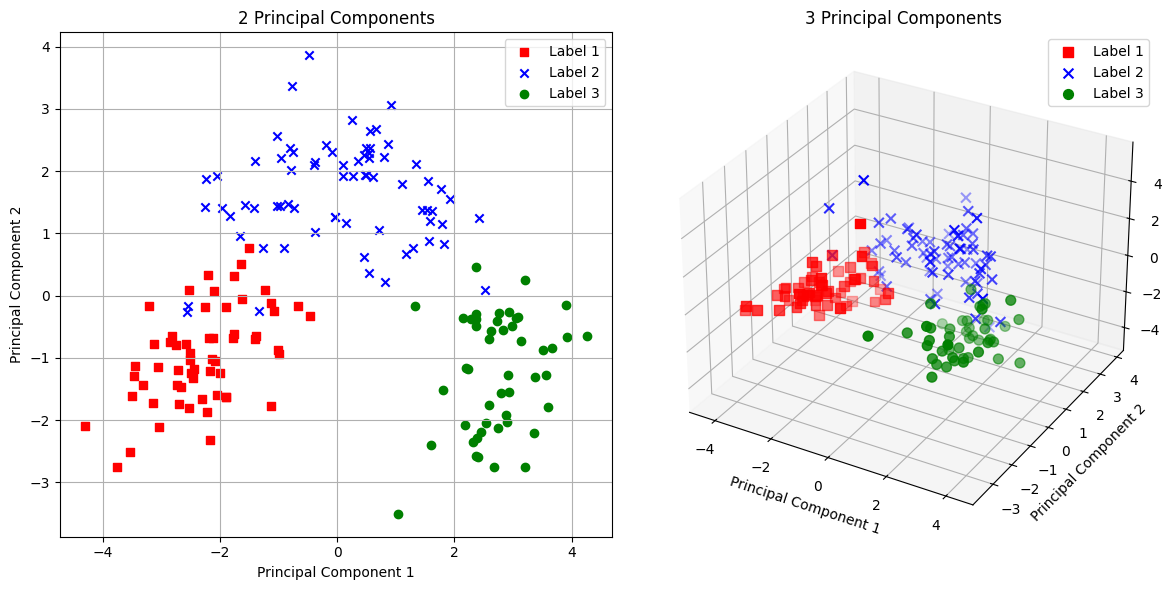

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

colors = ['r', 'b', 'g']  # Màu hiển thị, tương ứng với red, blue, green
markers = ['s', 'x', 'o']  # Marker cho mỗi nhãn

fig = plt.figure(figsize=(12, 6))

# 2 PC
ax1 = fig.add_subplot(121)
for l, c, m in zip(np.unique(y), colors, markers):
    ax1.scatter(X_proj_eig_2pc[y == l, 0], X_proj_eig_2pc[y == l, 1], c=c, label=f'Label {l}', marker=m)
ax1.set_xlabel('Principal Component 1')
ax1.set_ylabel('Principal Component 2')
ax1.set_title('2 Principal Components')
ax1.legend(loc='upper left')
ax1.grid()
ax1.legend()

# 3 PC
ax2 = fig.add_subplot(122, projection='3d')
for l, c, m in zip(np.unique(y), colors, markers):
    ax2.scatter(X_proj_eig_3pc[y == l, 0], X_proj_eig_3pc[y == l, 1], X_proj_eig_3pc[y == l, 2], c=c, label=f'Label {l}', marker=m, s=50)
ax2.set_xlabel('Principal Component 1')
ax2.set_ylabel('Principal Component 2')
ax2.set_zlabel('Principal Component 3')
ax2.set_title('3 Principal Components')
ax2.legend(loc='upper left')
ax2.grid()
ax2.legend()

plt.tight_layout()
plt.show()


## PCA với Singular Value Decomposition

Cho ma trận $\textbf{X} \in \mathbb{R}^{N\times d}$. Khi đó, ma trận $\textbf{X}$ có thể được viết dưới dạng:
$$
\textbf{X} = \textbf{USV}^T
$$
trong đó: 
- $\textbf{U} \in \mathbb{R}^{N\times N}, \textbf{V} \in \mathbb{R}^{N\times d}$ là các ma trận trực giao sao cho $\textbf{U}^T \textbf{U} = \textbf{I}_N, \textbf{V}^T \textbf{V} = \textbf{I}_d$ và $\textbf{S} \in \mathbb{R}^{N\times N}$ là ma trận đường chéo.
- $\textbf{U}$ là ma trận chứa các cột (column) được gọi là `left-singular vectors` được tạo bởi các vector riêng của $\textbf{X}\textbf{X}^T$.
- $\textbf{V}$ là ma trận chứa các cột (column) được gọi là `right-singular vectors` được tạo bởi các vector riêng của $\textbf{X}^T\textbf{X}$.
- $\textbf{S}$ là ma trận đường chéo chứa các singular values $s_i$

In [27]:
# SVD 
U, S, Vh = np.linalg.svd(X_std)

# Chiếu dữ liệu lên 2 thành phần chính
X_proj_svd_2pc = X_std @ Vh[:2].T
# Chiếu dữ liệu lên 2 thành phần chính
X_proj_svd_3pc = X_std @ Vh[:3].T

So sánh kết quả với thuật toán sử dụng Eigende-composition.

`X_proj_svd[i,j] == X_proj_eig[i,j], với mọi i,j`

In [28]:
np.allclose(X_proj_svd_2pc, X_proj_eig_2pc) 

True

In [29]:
np.allclose(X_proj_svd_3pc, X_proj_eig_3pc) 

True

Kiểm chứng công thức $\lambda_i = \displaystyle \frac{s_i^2}{N-1}$. 

Xem thêm: https://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca/134283#134283

In [30]:
np.allclose((S**2)/(N-1), eigenvals)

True

In [31]:
print((S**2)/(N-1)) # singular-values
print(eigenvals) # lambdas (eigen-values)

[4.70585025 2.49697373 1.44607197 0.91897392 0.85322818 0.64165703
 0.55102831 0.34849736 0.28887994 0.25090248 0.22578864 0.16877023
 0.10337794]
[4.70585025 2.49697373 1.44607197 0.91897392 0.85322818 0.64165703
 0.55102831 0.34849736 0.28887994 0.25090248 0.22578864 0.16877023
 0.10337794]


Trực quan kết quả

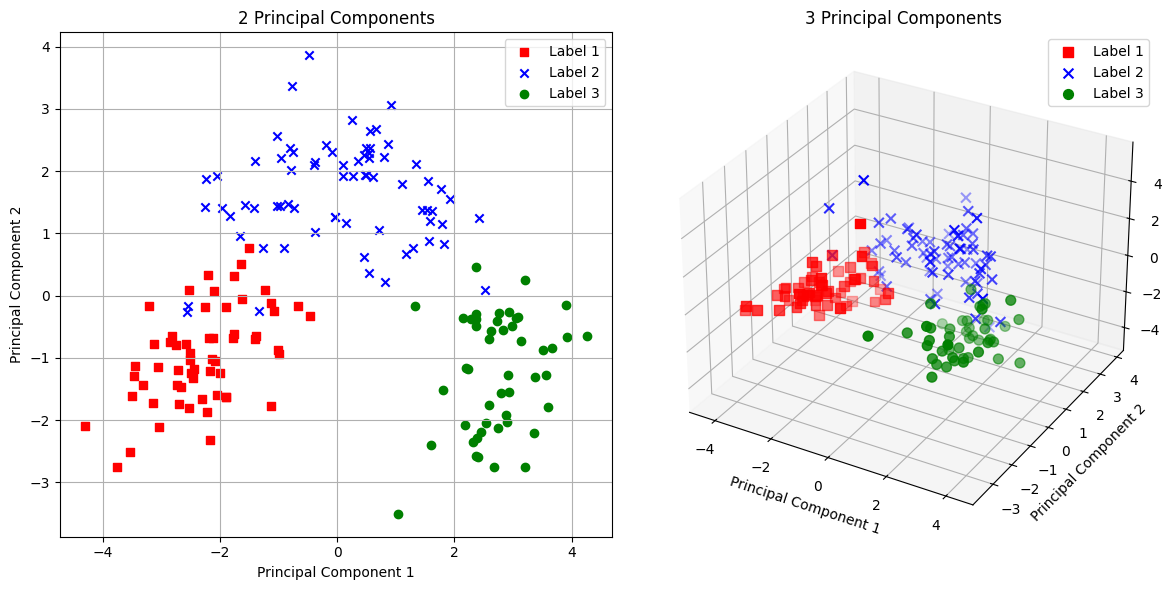

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

colors = ['r', 'b', 'g']  # Màu hiển thị, tương ứng với red, blue, green
markers = ['s', 'x', 'o']  # Marker cho mỗi nhãn

fig = plt.figure(figsize=(12, 6))

# 2 PC
ax1 = fig.add_subplot(121)
for l, c, m in zip(np.unique(y), colors, markers):
    ax1.scatter(X_proj_svd_2pc[y == l, 0], X_proj_svd_2pc[y == l, 1], c=c, label=f'Label {l}', marker=m)
ax1.set_xlabel('Principal Component 1')
ax1.set_ylabel('Principal Component 2')
ax1.set_title('2 Principal Components')
ax1.legend(loc='upper left')
ax1.grid()
ax1.legend()

# 3 PC
ax2 = fig.add_subplot(122, projection='3d')
for l, c, m in zip(np.unique(y), colors, markers):
    ax2.scatter(X_proj_svd_3pc[y == l, 0], X_proj_svd_3pc[y == l, 1], X_proj_svd_3pc[y == l, 2], c=c, label=f'Label {l}', marker=m, s=50)
ax2.set_xlabel('Principal Component 1')
ax2.set_ylabel('Principal Component 2')
ax2.set_zlabel('Principal Component 3')
ax2.set_title('3 Principal Components')
ax2.legend(loc='upper left')
ax2.grid()
ax2.legend()

plt.tight_layout()
plt.show()


## So sánh với hàm thư viện

In [33]:
from sklearn.decomposition import PCA

pca_2pc = PCA(n_components = 2)
X_pca_2pc = pca_2pc.fit_transform(X_std)

pca_3pc = PCA(n_components = 3)
X_pca_3pc = pca_3pc.fit_transform(X_std)


So sánh PCA 2 thành phần chính của thư viện và tự làm

In [34]:
print(">> Eigen vectors (from scratch): \n", eigenvecs[:2])
print("\n>> Eigen vectors (from scikit-learn): \n", pca_2pc.components_)

>> Eigen vectors (from scratch): 
 [[-0.1443294   0.24518758  0.00205106  0.23932041 -0.14199204 -0.39466085
  -0.4229343   0.2985331  -0.31342949  0.0886167  -0.29671456 -0.37616741
  -0.28675223]
 [-0.48365155 -0.22493093 -0.31606881  0.0105905  -0.299634   -0.06503951
   0.00335981 -0.02877949 -0.03930172 -0.52999567  0.27923515  0.16449619
  -0.36490283]]

>> Eigen vectors (from scikit-learn): 
 [[ 0.1443294  -0.24518758 -0.00205106 -0.23932041  0.14199204  0.39466085
   0.4229343  -0.2985331   0.31342949 -0.0886167   0.29671456  0.37616741
   0.28675223]
 [-0.48365155 -0.22493093 -0.31606881  0.0105905  -0.299634   -0.06503951
   0.00335981 -0.02877949 -0.03930172 -0.52999567  0.27923515  0.16449619
  -0.36490283]]


Trực quan kết quả

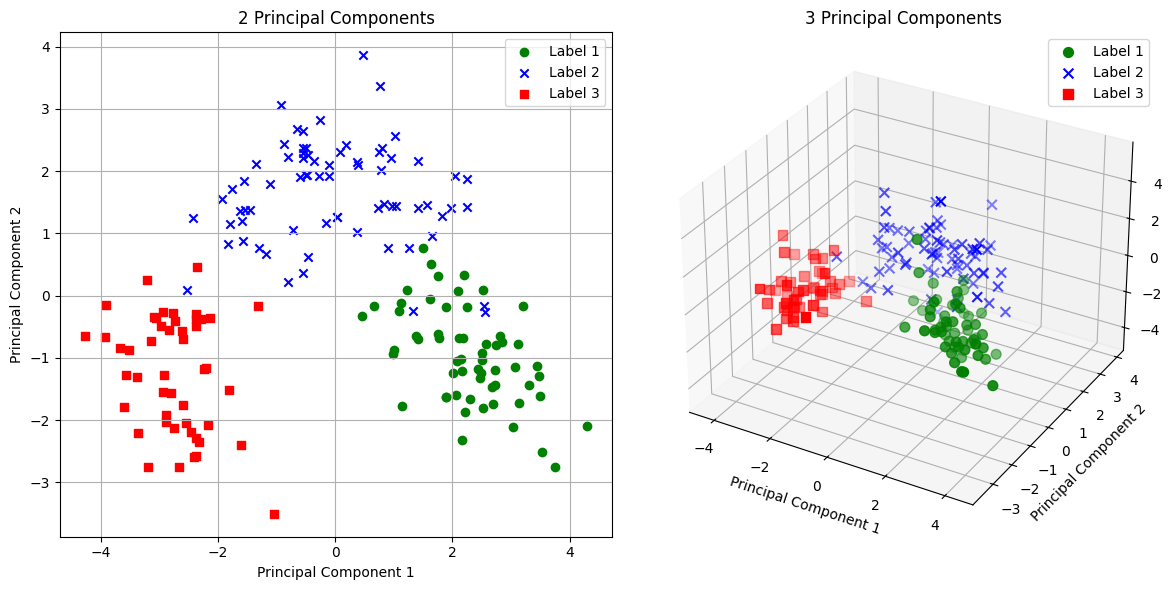

In [35]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

colors = ['g', 'b', 'r']  # Màu hiển thị, tương ứng với red, blue, green
markers = ['o', 'x', 's']  # Marker cho mỗi nhãn

fig = plt.figure(figsize=(12, 6))

# 2 PC
ax1 = fig.add_subplot(121)
for l, c, m in zip(np.unique(y), colors, markers):
    ax1.scatter(X_pca_2pc[y == l, 0], X_pca_2pc[y == l, 1], c=c, label=f'Label {l}', marker=m)
ax1.set_xlabel('Principal Component 1')
ax1.set_ylabel('Principal Component 2')
ax1.set_title('2 Principal Components')
ax1.legend(loc='upper left')
ax1.grid()
ax1.legend()

# 3 PC
ax2 = fig.add_subplot(122, projection='3d')
for l, c, m in zip(np.unique(y), colors, markers):
    ax2.scatter(X_pca_3pc[y == l, 0], X_pca_3pc[y == l, 1], X_pca_3pc[y == l, 2], c=c, label=f'Label {l}', marker=m, s=50)
ax2.set_xlabel('Principal Component 1')
ax2.set_ylabel('Principal Component 2')
ax2.set_zlabel('Principal Component 3')
ax2.set_title('3 Principal Components')
ax2.legend(loc='upper left')
ax2.grid()
ax2.legend()

plt.tight_layout()
plt.show()


In [36]:
# 3D visualization

import matplotlib.pyplot as plt
import plotly.express as px # package for 3D visualization
# scatter with predicted clusters
fig = px.scatter_3d(X_pca_3pc, 
                    x=X_pca_3pc[:,0], 
                    y=X_pca_3pc[:,1], 
                    z=X_pca_3pc[:,2], 
                    color=y, 
                    width=800, 
                    height=400)
# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

# Tham khảo
1. [Making sense of principal component analysis eigenvectors eigenvalues](https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues)

2. [Relationship between SVD and PCA, how to use SVD to perform PCA](https://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca/134283#134283)

3. [Principal component Analysis with Linear Algebra](https://www.math.union.edu/~jaureguj/PCA.pdf?ref=jeremyjordan.me)

4. [Principal component Analysis tutorial](https://web.mit.edu/be.400/www/SVD/Singular_Value_Decomposition.htm)

5. Chapter 8. [Johnson, R. A., Wichern, D. W. (2002). Applied multivariate statistical analysis. Upper Saddle River, NJ: Prentice Hall. ISBN: 0130925535](https://ostad.hormozgan.ac.ir/ostad/UploadedFiles/863845/97050509-3761826667770356.pdf)

6. Chapter 12.1. [Bishop, Christopher M. (2006). Pattern recognition and machine learning. New York :Springer,](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf)